In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

feature_names = pd.read_csv('../../Dataset/STS/Data_Names.csv')
header = feature_names['features'].tolist()
#set header for the dataset
dataset = pd.read_csv('../../Dataset/STS/Data_STS.csv')
dataset.columns = header
dataset.head()

,Stand-to-stand time,Sit-to-stand time,Stand-to-sit time,M_hip vertical range,M_hip depth range,M_hip max vertical velocity,M_hip min vertical velocity,M_hip max depth velocity,M_hip min depth velocity,Knee flexo-extension range,...,M_shoulder min vertical velocity,M_shoulder max depth velocity,Spine flexo-extension range,Spine flexo-extension max velocity,Spine flexo-extension min velocity,Spine abduction-adduction range,Spine abduction-adduction max velocity,Spine abduction-adduction min velocity,Heart Rate,Fatigue Condition
0,1.1494,1.0219,1.0460,1.01510,0.96060,0.98215,1.3183,0.91062,0.92036,1.00250,...,0.97932,1.00380,1.2178,0.97569,0.98219,0.99926,1.28480,1.06290,1.2469,1
1,1.2150,1.0994,1.0804,0.87648,0.89024,0.99210,1.3177,0.93530,0.92490,0.98812,...,0.94320,1.07840,1.3523,0.95966,0.94077,0.96024,1.13840,1.01810,1.2537,1
2,1.0712,0.9929,1.0965,0.89684,0.95366,1.00890,1.1206,0.95903,0.93991,1.06500,...,0.97629,1.03280,1.3074,0.88624,0.92409,0.94021,0.96528,0.85533,1.2622,1
3,1.3106,1.3771,1.2195,1.08700,1.10530,1.00650,1.4565,1.07270,1.15530,1.07220,...,1.14290,0.94031,1.4270,1.00150,1.01930,1.01720,1.41930,1.06020,1.2677,2
4,1.2767,1.2298,1.2643,1.12390,1.15170,0.95774,1.3920,1.03950,1.06770,1.00600,...,1.08630,1.15530,1.5117,1.03520,1.01060,1.01600,1.16110,1.04280,1.3722,2


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
dataset.iloc[:, -1] = dataset.iloc[:, -1]
X = dataset.iloc[:, :-1]  # Features
y = dataset.iloc[:, -1] -1   # Target

In [4]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert labels to categorical
y_categorical = to_categorical(y)
y_categorical

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
# Shuffle the data
X_scaled, y_categorical = shuffle(X_scaled, y_categorical, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42)

# Number of unique classes in the target variable
num_classes = y_train.shape[1]


# Building the DNN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), name='dense_0'),
    Dense(32, activation='relu', name='dense_1'),
    Dense(3, activation='relu', name='dense_2'),
    # Dense(3, activation='relu', name='dense_3'),
    Dense(num_classes, activation='softmax')  # Output layer
])

In [6]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=100,  # how many epochs to wait before stopping
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Set the learning rate
learning_rate = 0.01

# Create the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,  # factor by which the learning rate will be reduced
    patience=10,  # number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,  # lower bound on the learning rate
    verbose=1
)
lr_callback = tf.keras.callbacks.LearningRateScheduler(reduce_lr)

class PrintLR(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
        
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        elif hasattr(lr, 'eval'):
            lr = lr.eval(session=tf.compat.v1.Session())
        print(f'Epoch {epoch+1}: Learning rate is {lr}.')
    
    def on_epoch_end(self, epoch, logs=None):
        # Retrieve the current learning rate from the optimizer
        current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        # Append the current learning rate to the list
        self.learning_rates.append(current_lr)

lr_tracker = PrintLR()
callbacks = [lr_tracker, early_stopping, reduce_lr]


# Initialize the optimizer with the learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compiling the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Pass the callback to the fit method
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=16,
    callbacks=callbacks  # include it here
)

Epoch 1: Learning rate is 0.009999999776482582.
Epoch 1/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.9668 - accuracy: 0.5938 - val_loss: 0.7372 - val_accuracy: 0.7642
Epoch 2: Learning rate is 0.009999999776482582.
Epoch 2/1000
27/27 [==============================] - 0s 960us/step - loss: 0.6717 - accuracy: 0.7506 - val_loss: 0.7451 - val_accuracy: 0.7547
Epoch 3: Learning rate is 0.009999999776482582.
Epoch 3/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.4841 - accuracy: 0.8432 - val_loss: 0.5074 - val_accuracy: 0.8302
Epoch 4: Learning rate is 0.009999999776482582.
Epoch 4/1000
27/27 [==============================] - 0s 961us/step - loss: 0.4208 - accuracy: 0.8480 - val_loss: 0.7146 - val_accuracy: 0.7642
Epoch 5: Learning rate is 0.009999999776482582.
Epoch 5/1000
27/27 [==============================] - 0s 942us/step - loss: 0.2812 - accuracy: 0.8955 - val_loss: 0.4082 - val_accuracy: 0.8396
Epoch 6: Learning rate is 0.0099999997764825

In [8]:
# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

5/5 [==============================] - 0s 605us/step - loss: 0.3586 - accuracy: 0.8788
Test accuracy: 0.8787878751754761
Test loss: 0.3585723042488098


In [9]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
confusion_matrix(y_test, y_pred)

array([[41,  0,  0],
       [ 2, 45,  4],
       [ 0, 10, 30]], dtype=int64)

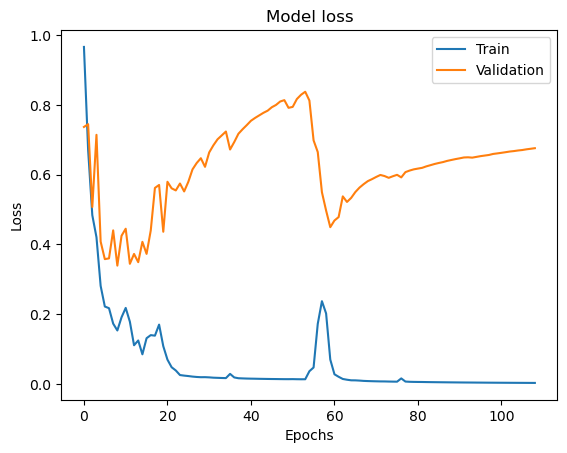

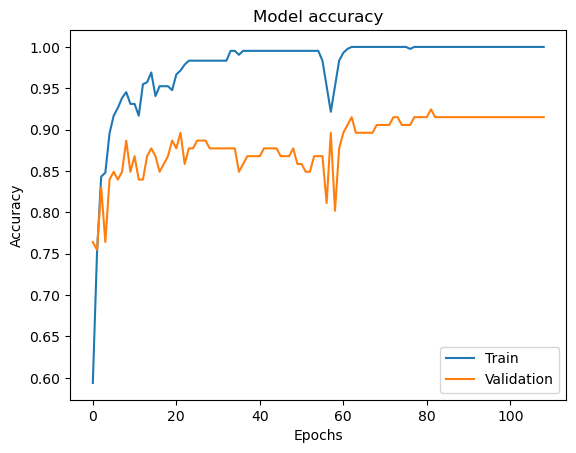

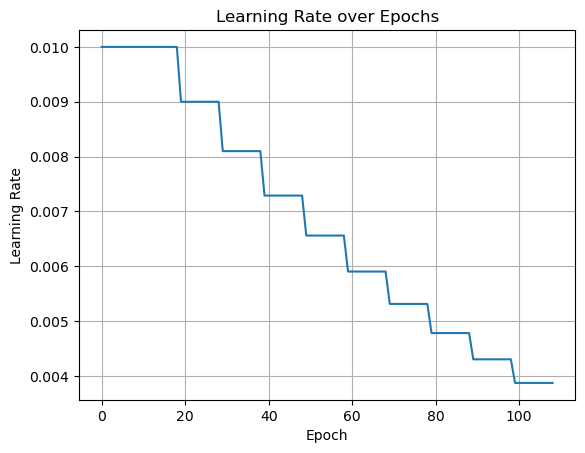

In [10]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plotting
# plt.figure(figsize=(8, 8))
plt.plot(lr_tracker.learning_rates)
plt.title("Learning Rate over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)

In [11]:
# Save the model
tf.keras.models.save_model(model, '../../Model/STS/sts_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../../Model/STS/sts_model\assets


In [12]:
from tensorflow.keras.models import Model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 64)                2176      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
Total params: 4,367
Trainable params: 4,367
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Assume 'original_model' is your pre-trained model
model_without_softmax = Model(inputs=model.input, 
                              outputs=model.get_layer("dense_2").output)
model_without_softmax.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0_input (InputLayer)   [(None, 33)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 64)                2176      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 4,355
Trainable params: 4,355
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Save the model
tf.keras.models.save_model(model_without_softmax, '../../Model/STS/sts_model_without_softmax')

INFO:tensorflow:Assets written to: ../../Model/STS/sts_model_without_softmax\assets
